In [207]:
from ipywidgets import widgets as W, HBox, Layout, VBox, Button
from matplotlib import pyplot as plt
from IPython import display as D
import sounddevice as sd
from typing import List, Tuple
import numpy as np
from os.path import expanduser

%matplotlib inline

D.display(D.HTML("<style>.container{width: 100%}</style>"))

In [283]:
def plot_sines(arr, add=False, duration=0.01, fs=44100):
    plt.figure(figsize=(28, 8))
    n = int(duration * fs)
    t = 2 * np.pi * np.arange(n)/fs
    sines = []
    for f, a in arr:
        sines.append(a * np.sin(f * t))
    if add:
        plt.plot(t, sum(sines, np.zeros_like(t)))
    else:
        for s in sines:
            plt.plot(t, s)
    plt.xlabel("Time, s", fontsize=20)
    plt.ylabel("Delta Pressure, r.u.", fontsize=20)

def make_natural_interval(freq, delta=1):
    natural_k = list(reversed([
        (0, 1),
        (1, 8/7),
        (2, 7/6),
        (3, 6/5),
        (4, 5/4),
        (5, 4/3),
        (7, 3/2),
        (12, 2)
    ]))
    p = delta
    f = freq
    while p > 0:
        for i, k in natural_k:
            if p >= i:
                p -= i
                f *= k
    return f

def make_eq_interval(freq, delta=1):
    return freq * np.power(2, delta/12)


def _gen_sine(w, n):
    x = np.arange(0, n)
    return np.sin(w * x)

def gen_sound(freqs, ampls, duration=1., fs=44100, dim_dur=0.2, app_dur=0.1):
    n = int(fs * duration)
    w0 = 2 * np.pi / fs
    arr = np.zeros(n)
    for f, a in zip(freqs, ampls):
        arr += a * _gen_sine(w0 * f, n)
    dim_n = int(fs * dim_dur)
    app_n = int(fs * app_dur)
    for i in range(n - dim_n, n):
        arr[i] *= (n - i) / dim_n
    for i in range(app_n):
        arr[i] *= i / app_n
    return arr

def play_sound(sound):
    mx = max(sound)
    sd.play(sound / mx)


def plot_freqs(freqs, ampls, fs=44100, duration_min=0.05, duration_max=0.3):
    plt.figure(figsize=(27, 8))
    plt.subplot(222)
    x = np.stack((freqs, freqs), axis=1).T
    y = np.stack((ampls, np.zeros_like(ampls)), axis=1).T
    plt.plot(x, y, 'b-', linewidth=5)
    plt.xlabel("Frequency, Hz")
    plt.ylabel("Amplitude")
    xleft = -10
    xright = max(freqs) + 10
    plt.xlim(xleft, xright)
    plt.hlines(0, xleft, xright, colors='k')
    plt.subplot(223)
    n = int(duration_min * fs)
    t = np.arange(n)/fs
    sines = []
    for f, a in zip(freqs, ampls):
        sines.append(2 * np.pi * a * np.sin(f * t))
    plt.plot(t, sum(sines, np.zeros_like(t)))
    plt.xlabel("Time, s")
    plt.ylabel("Delta Pressure, sum, r.u.")
    plt.subplot(221)
    plt.title('Waves')
    for s in sines:
        plt.plot(t, s)
    plt.ylabel("Delta Pressure, separate, r.u.")
    plt.subplot(224)
    n = int(duration_max * fs)
    t = np.arange(n)/fs
    sines = []
    for f, a in zip(freqs, ampls):
        sines.append(a * np.sin(2 * np.pi * f * t))
    plt.plot(t, sum(sines, np.zeros_like(t)))
    plt.xlabel("Time, s")
    plt.ylabel("Delta Pressure, r.u.")
    plt.show()


def createFreqControls(fr: List[Tuple[float, float]]=None, n: int = 2, duration=2., delta_freq=0.3):
    cache = {}
    def change_params(*args, **kwargs):
        controls = cache.get('controls', [])
        freqs = []
        ampls = []
        for hbox in controls:
            if hbox.children[0].value:
                freqs.append(hbox.children[1].value)
                ampls.append(hbox.children[2].value)
        cache['freqs'] = freqs
        cache['ampls'] = ampls

    def plot(*args, **kwargs):
        D.clear_output()
        D.display(cache.get('vbox', None))
        D.display(plot_freqs(cache.get('freqs', []), cache.get('ampls', [])))

    def change_params_builder(pl=False):
        def func(*args, **kwargs):
            change_params(*args, **kwargs)
            if pl:
                plot()
        return func

    def getFreqControl(def_freq=None, def_ampl=None):
        chkb = W.Checkbox(
            value=True,
            layout=Layout(margin='0', padding='0', width='30px'),
            style={'description_width': '0'}
        )
        chkb.observe(change_params_builder(False))
        freq = W.BoundedFloatText(
            def_freq or 440, min=0, max=40000, step=0.01, description='Hz: ',
            layout=Layout(width='130px', margin='0'),
            style={'description_width': '40px'}
        )
        freq.observe(change_params_builder(False))
        ampl = W.FloatSlider(
            def_ampl or 100, min=0, max=100, step=0.1,
            description='',
            layout=Layout(width='220px', margin='0'),
            style={'description_width': '0'}
        )
        ampl.observe(change_params_builder(False))
        return HBox([chkb, freq, ampl])

    def add_control_builder(k=1, fr=None):
        def func(*args, **kwargs):
            controls = cache.setdefault('controls', [])
            for i in range(k):
                if fr is not None:
                    def_freq, def_ampl = fr[i]
                else:
                    last_control = controls[-1] if len(controls) > 0 else None
                    pre_last = controls[-2] if len(controls) > 1 else None
                    if pre_last is not None:
                        def_freq_p = pre_last.children[1].value
                    else:
                        def_freq_p = 0
                    if last_control is not None:
                        def_freq = 2 * last_control.children[1].value - def_freq_p
                        def_ampl = last_control.children[2].value * delta_freq
                    else:
                        def_freq = None
                        def_ampl = None
                controls.append(getFreqControl(def_freq=def_freq, def_ampl=def_ampl))
            cache['vbox'] = VBox(controls + [cache['btn_row']])
            change_params()
            plot()
        return func

    def play(*args, **kwargs):
        play_sound(gen_sound(cache.get('freqs', []), cache.get('ampls', []), duration=cache['btn_row'].children[-1].value))

    btn_plot = Button(description="Plot")
    btn_plot.on_click(plot)
    btn_add = Button(description="Add freq")
    btn_add.on_click(add_control_builder(1))
    btn_play = Button(description="Play sound")
    btn_play.on_click(play)
    snd_dur = W.FloatSlider(duration, min=0.4, max=10, description="s.", style={'description_width': '20px'})

    cache['btn_row'] = HBox([btn_add, btn_plot, btn_play, snd_dur])

    if fr is not None:
        n = len(fr)

    add_control_builder(max(0, n - len(cache.get('controls', []))), fr=fr)()

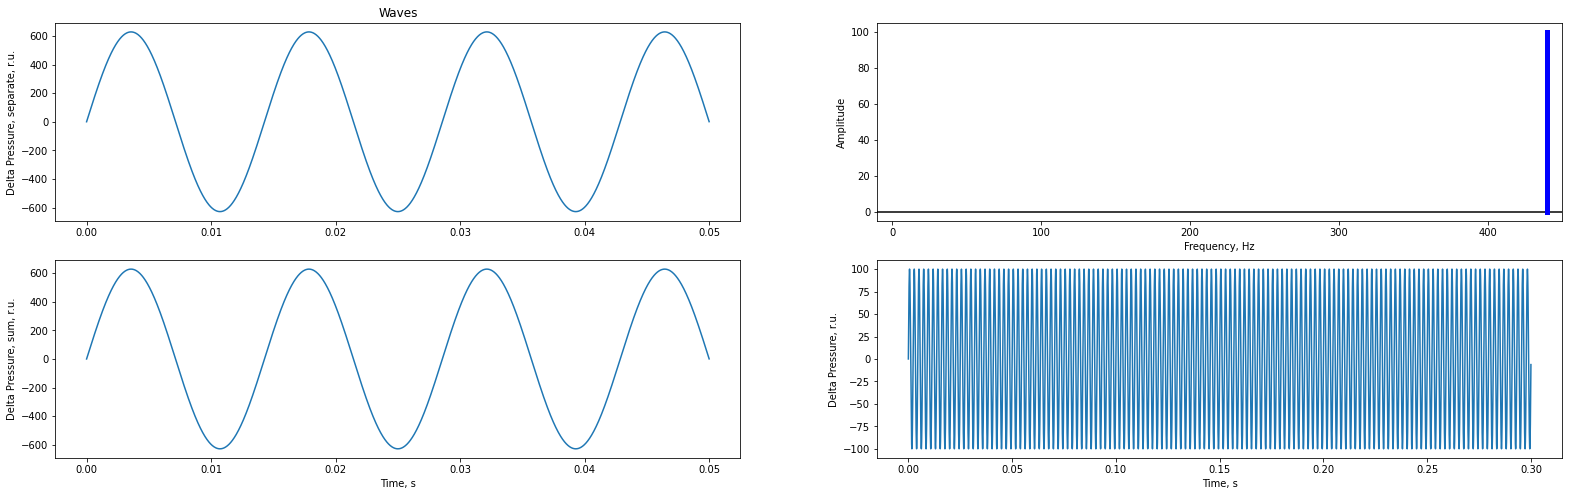

None

In [285]:
# Частота - Герцы

createFreqControls([(440, 100)])

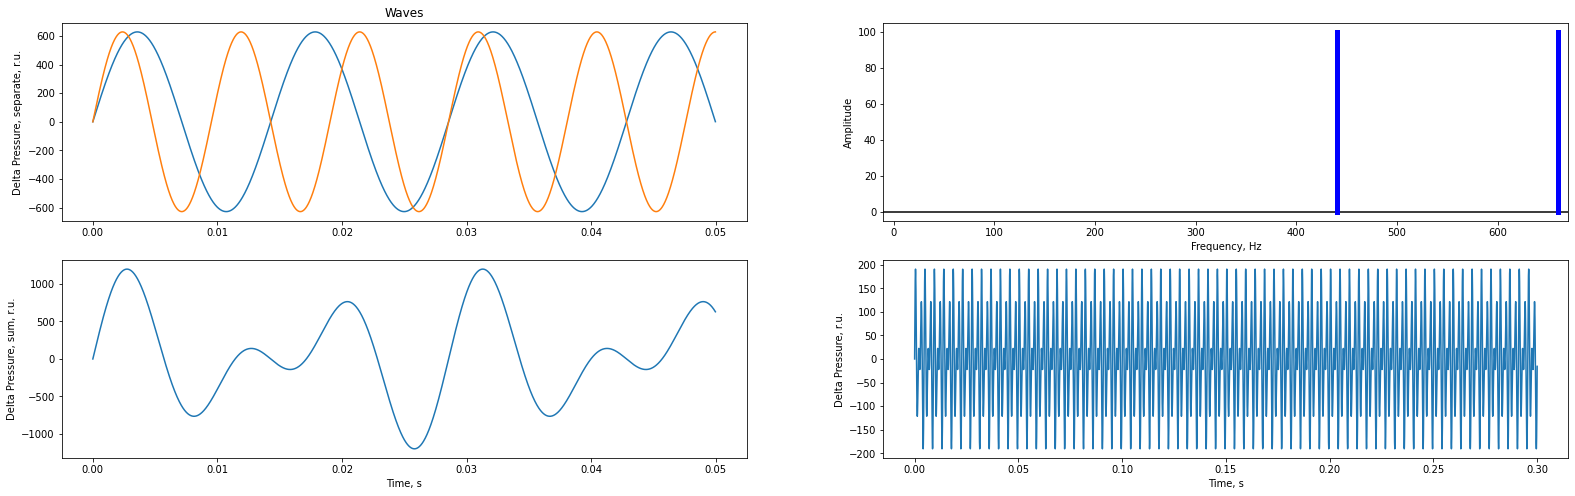

None

In [286]:
# Интервалы - комбинации синусоид

# 3 : 2 = квинта
createFreqControls([(440, 100), (660, 100)])

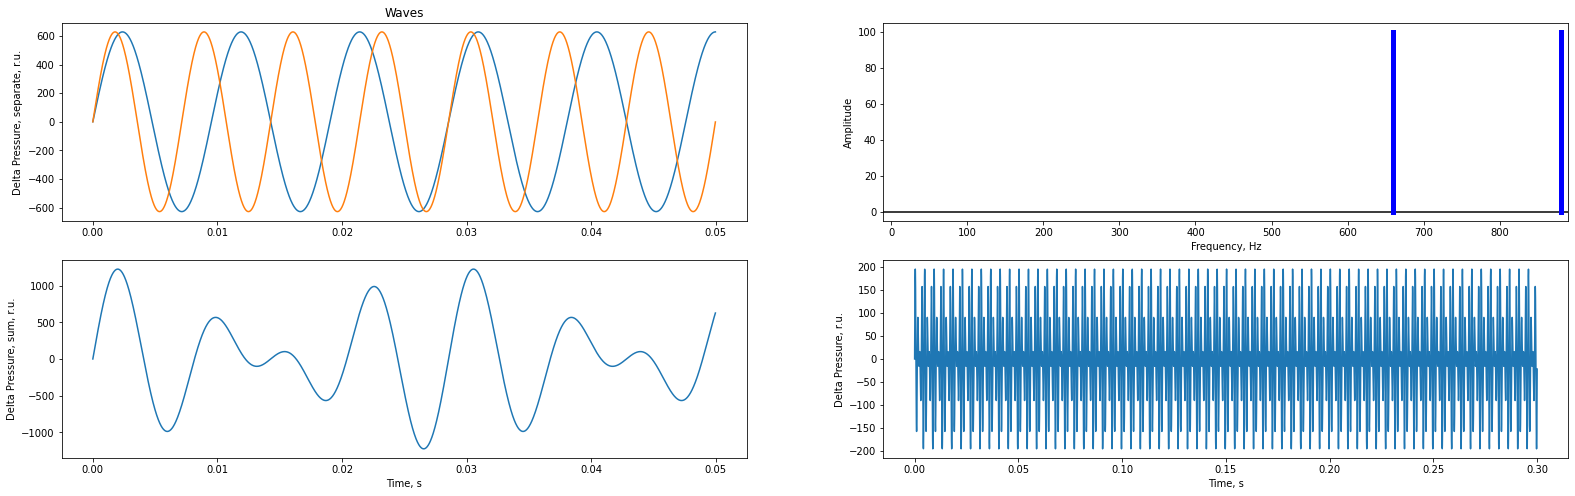

None

In [287]:
# Интервалы - комбинации синусоид

# 4 : 3 = кварта
createFreqControls([(660, 100), (880, 100)])

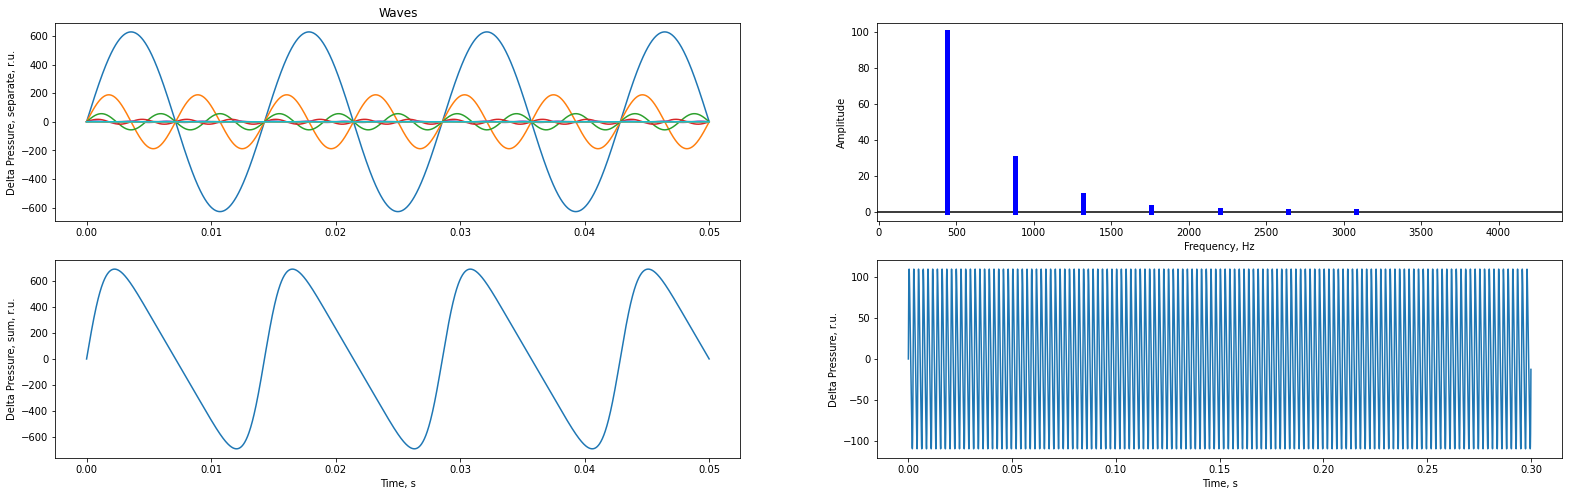

None

In [288]:
# Но звук сложнее - состоит из гармоник и обертонов

createFreqControls(n=10)

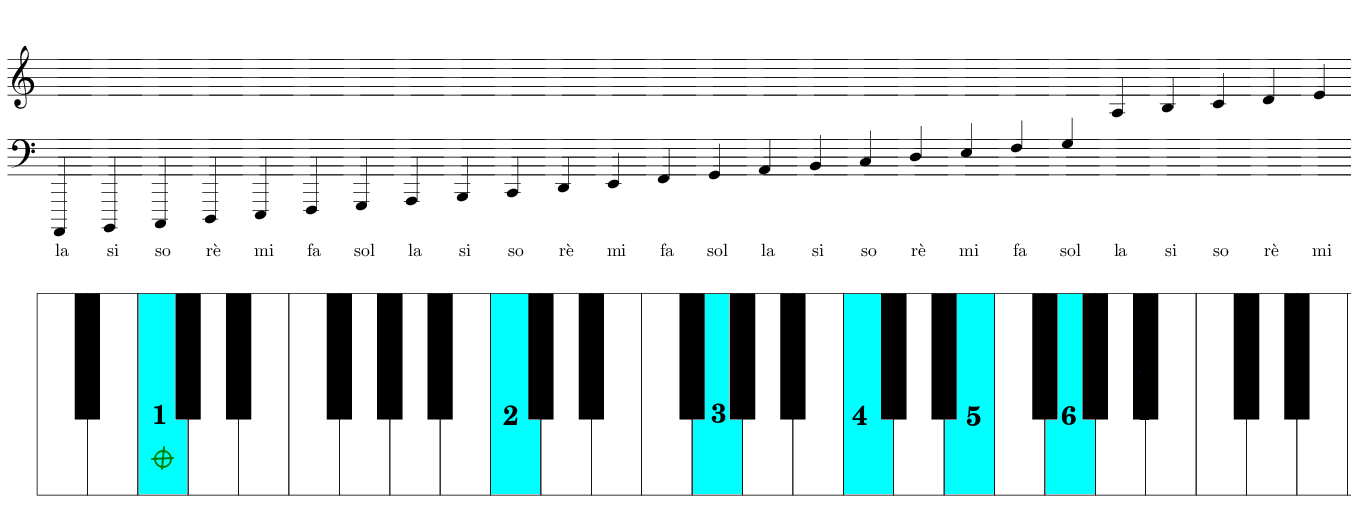

In [264]:
# Можно расположить гармоники на клавиатуре


D.Image(filename=expanduser("~/Media/music_images/kb_color.png"))

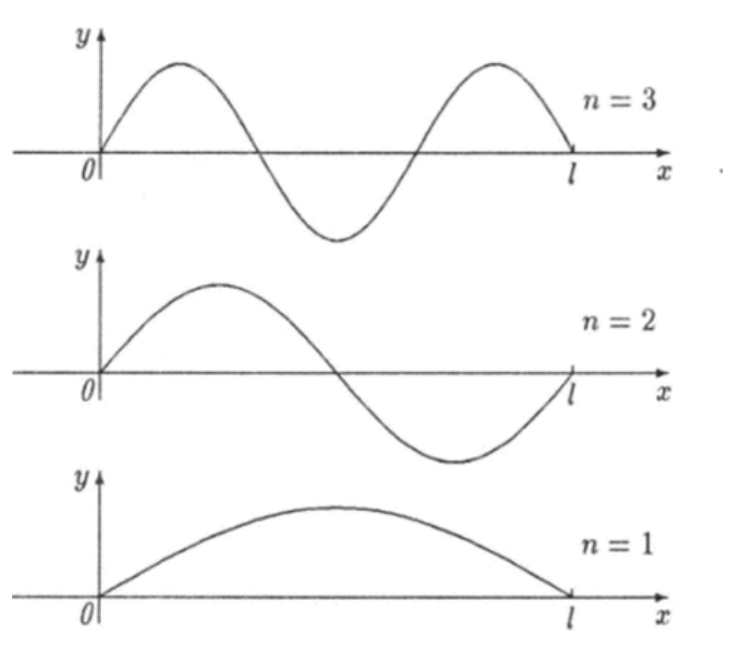

In [265]:
D.Image(filename=expanduser("~/Media/music_images/string.png"))

# Гармоники получаются из-за свойств колебаний в упругих средах.

## Струна

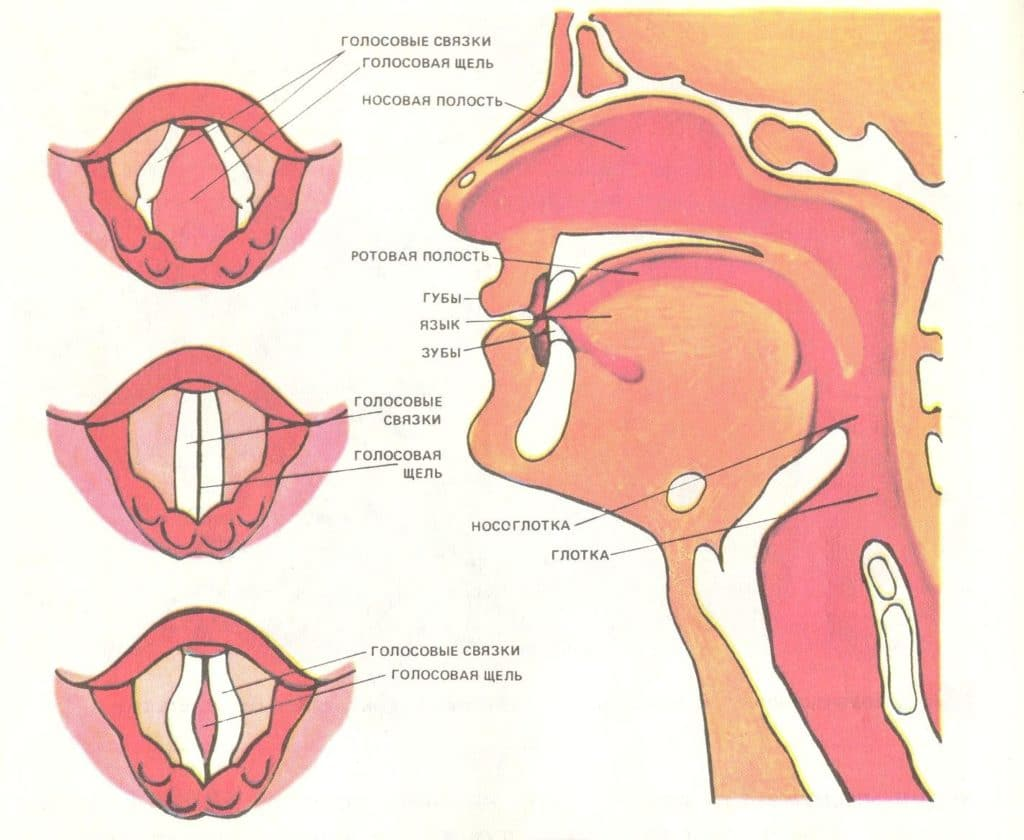

In [266]:
D.Image(filename=expanduser("~/Media/music_images/larynx.jpg"))

# Гармоники получаются из-за свойств колебаний в упругих средах.

## Голосовая щель

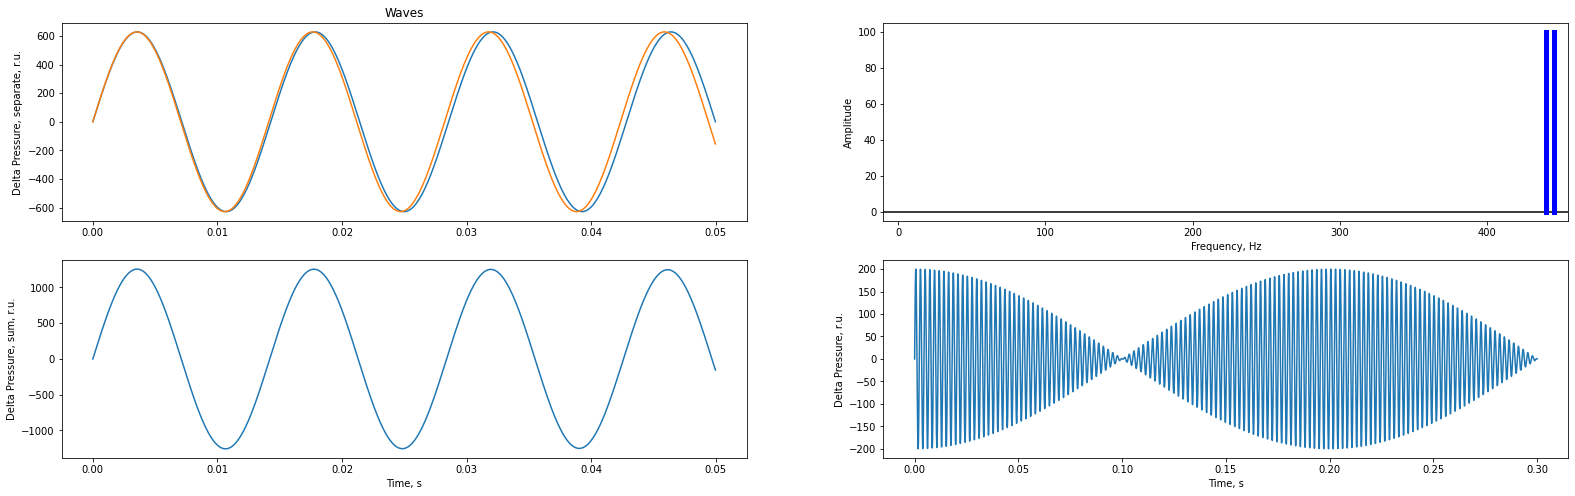

None

In [289]:
# Теперь поговорим про чистоту тона. Как вообще можно петь чисто?

createFreqControls([(440, 100), (445, 100)])

In [290]:
# Существуют ли чистые тона?

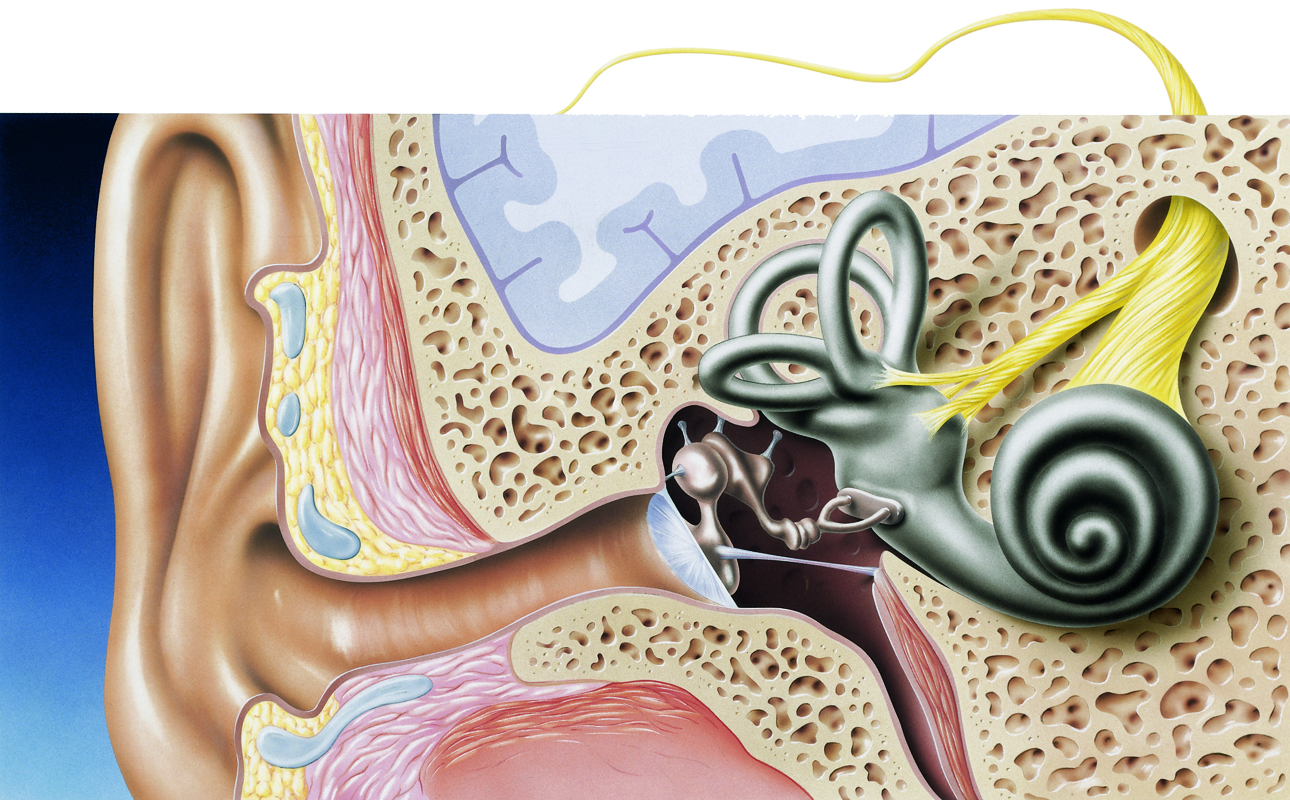

In [291]:
# 2. Анатомия

## Ухо

D.Image(filename=expanduser("~/Media/music_images/ear1.jpg"))

# Внешнее, среднее, внутреннее

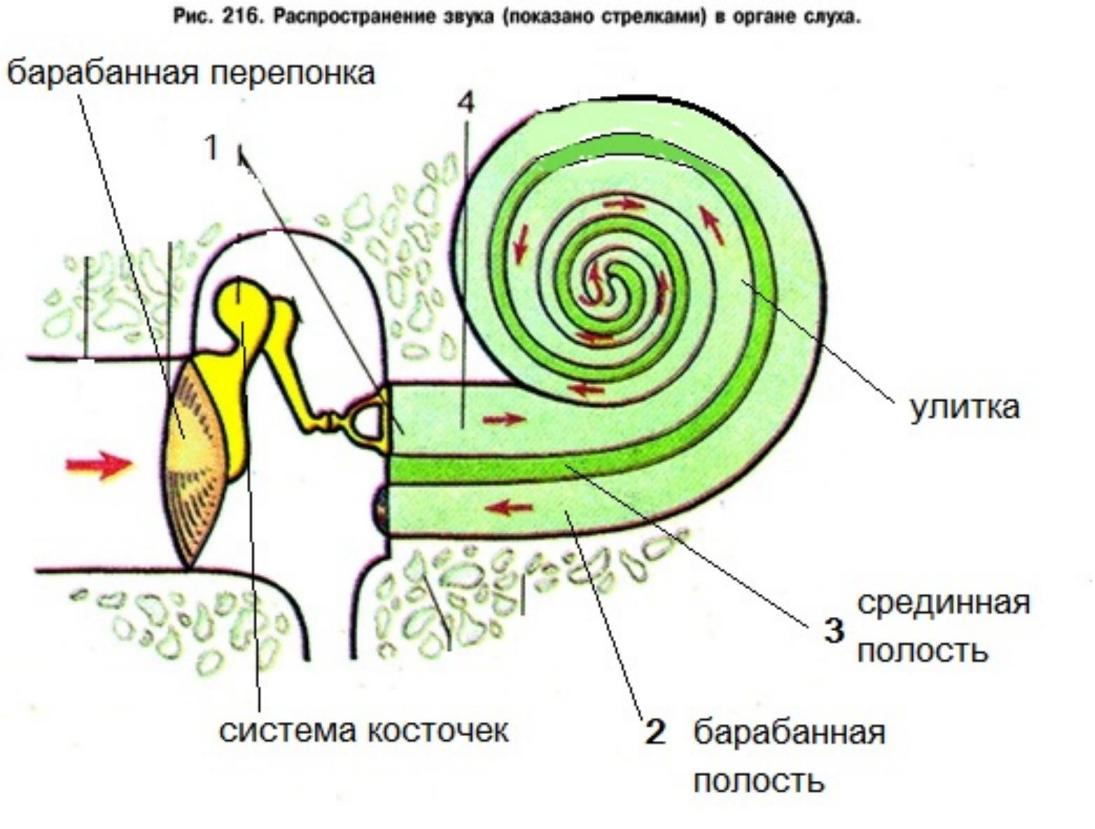

In [292]:
## Ухо

D.Image(filename=expanduser("~/Media/music_images/ear2.jpg"))

# Так передаются колебания воздуха к слуховым сенсорам

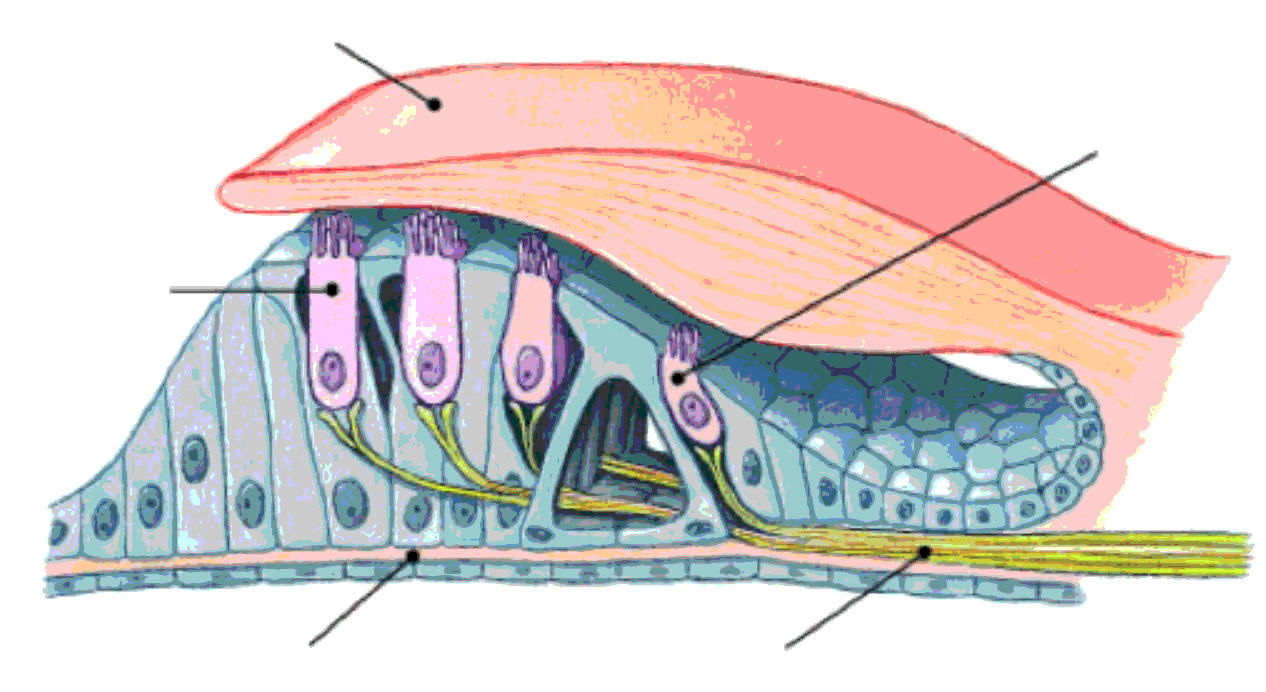

In [293]:
## Орган корти

D.Image(filename=expanduser("~/Media/music_images/korti1.png"))

# Так передаются колебания воздуха к слуховым сенсорам

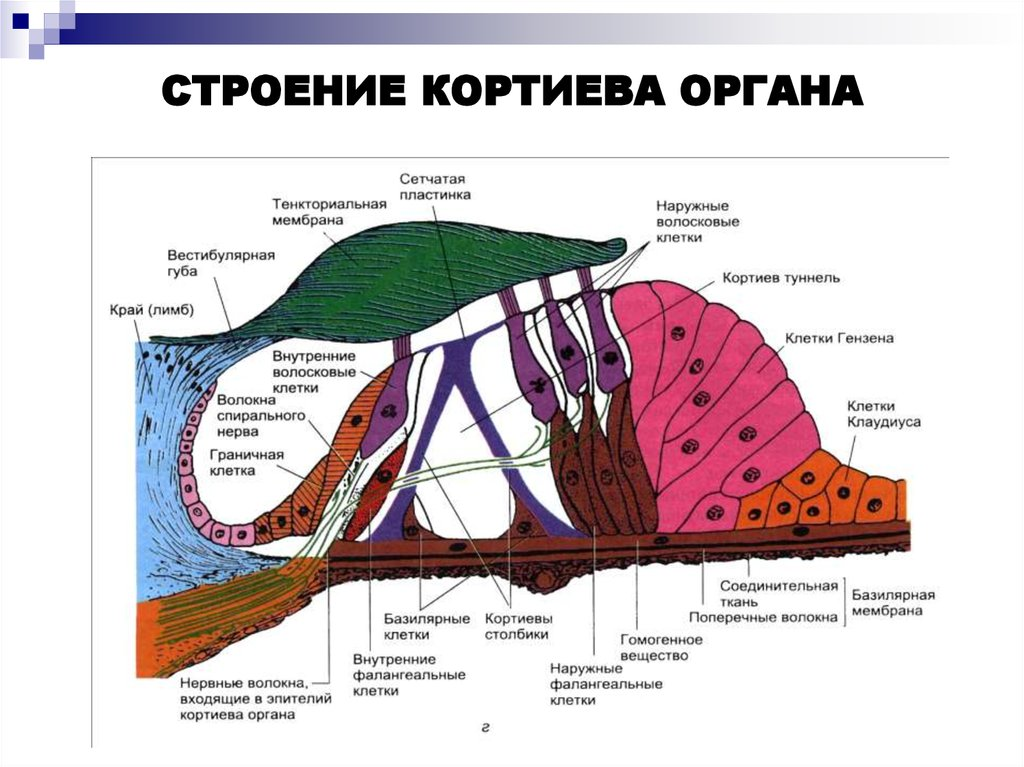

In [294]:
## Орган корти

D.Image(filename=expanduser("~/Media/music_images/korti2.jpg"))

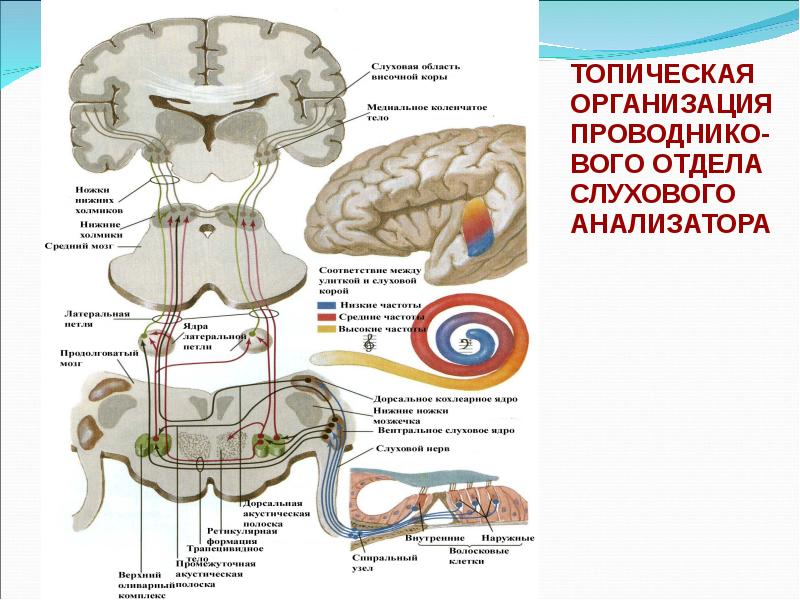

In [295]:
## Проводящие пути слухового анализатора

D.Image(filename=expanduser("~/Media/music_images/brain.jpg"))

In [296]:
# КОНЕЦ ! Дальше - доп материал

# Разные виды музыкального слуха

In [297]:
intervals = [4, 3, 5]

# Натуральный строй
row_natural = [440]
for p in intervals:
    row_natural.append(make_natural_interval(row_natural[-1], p))

# Равномерно-темперированный строй
row_eq = [440]
for p in intervals:
    row_eq.append(make_eq_interval(row_eq[-1], p))

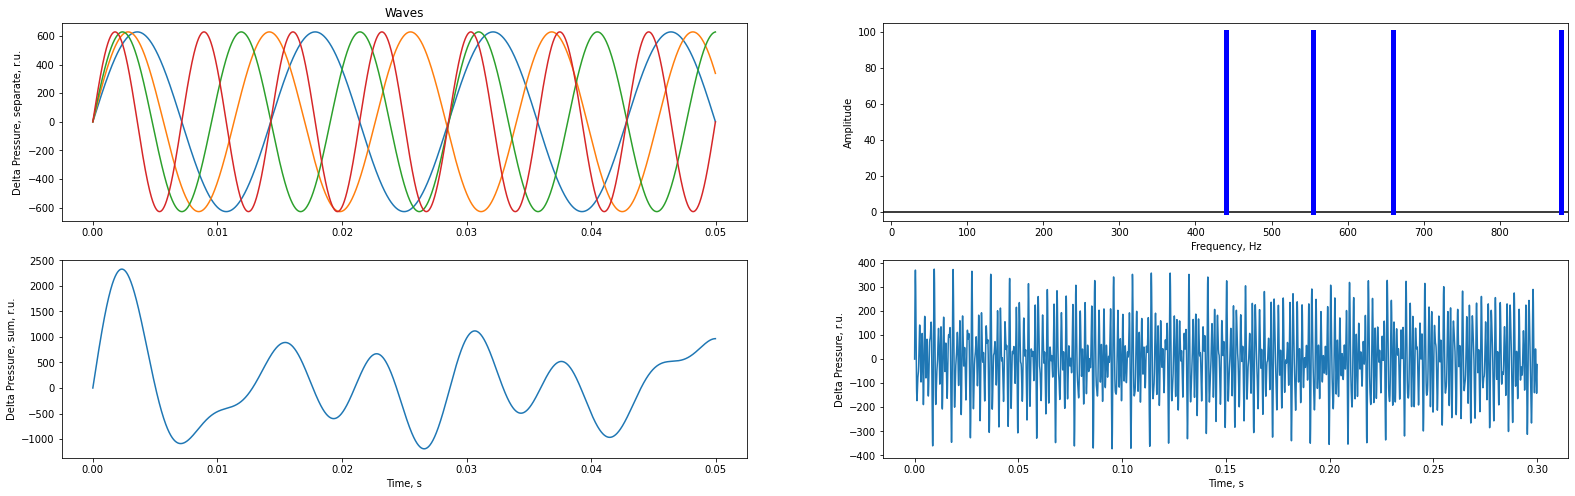

None

In [298]:
# Равномерно темперированный строй
createFreqControls([(f, 100) for f in row_eq])

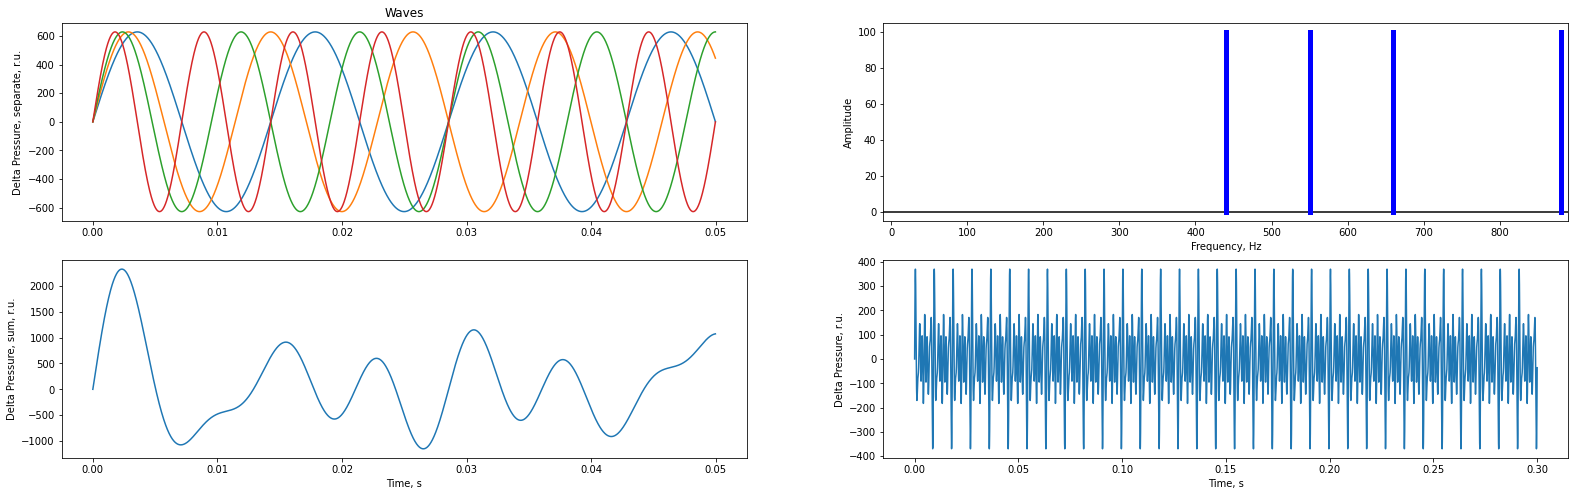

None

In [299]:
# Натуральный строй
createFreqControls([(f, 100) for f in row_natural])

In [300]:
# Квинтовый круг

intervals = [7] * 6

# Натуральный строй
q_row_natural = [220]
for p in intervals:
    q_row_natural.append(make_natural_interval(make_natural_interval(q_row_natural[-1], p), p)/2)

# Равномерно-темперированный строй
q_row_eq = [220]
for p in intervals:
    q_row_eq.append(make_eq_interval(make_eq_interval(q_row_eq[-1], p), p)/2)

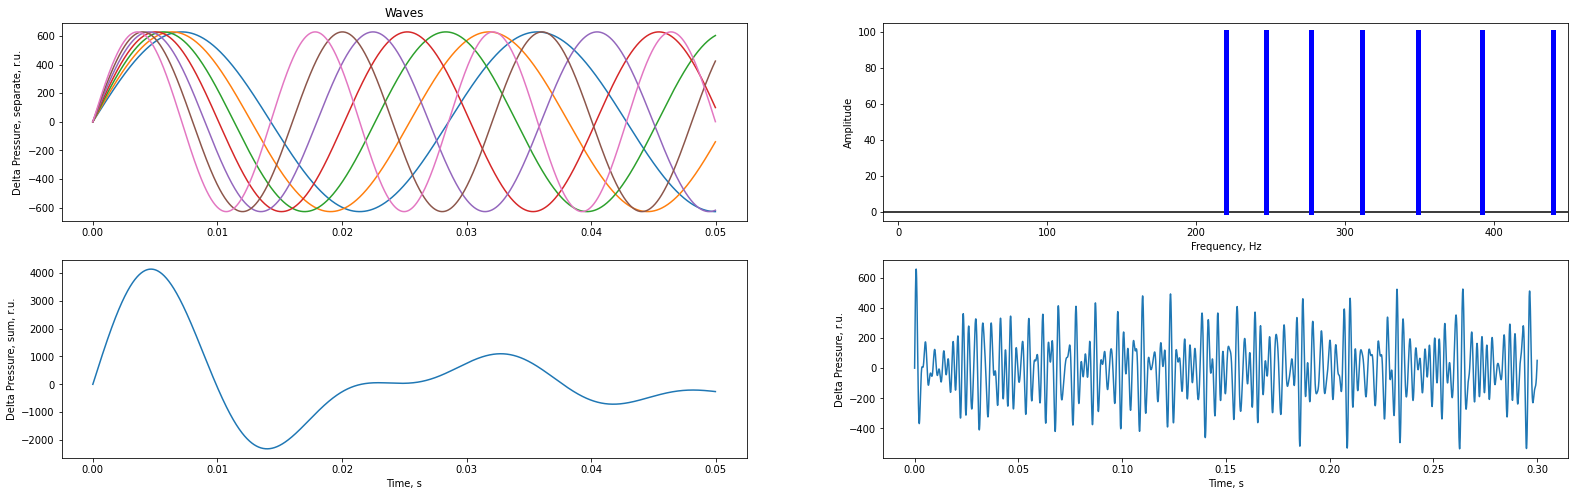

None

In [301]:
# Равномерно темперированный строй
createFreqControls([(f, 100) for f in q_row_eq])

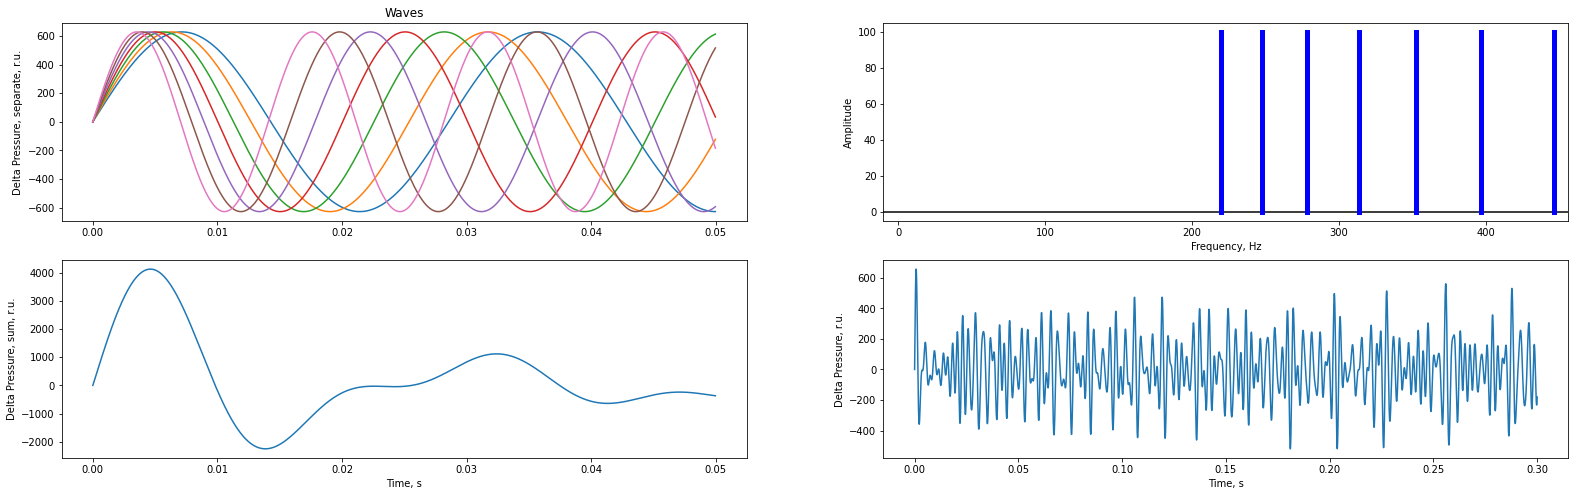

None

In [302]:
# Натуральный строй
createFreqControls([(f, 100) for f in q_row_natural])